**Goal** - In this notebook, I will demonstrate the process of Exploratory Data Analysis through a customer analytics case study. I have picked a customer churn dataset available on IBM sample Data Sets for this exercise. (https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113) 

**Business Problem** - 
A fictional telco company provides home phone and Internet services to 7043 customers in California. We have customer churn data indicating which customers left, stayed or signedup for their services in the last month. Demographics and etc data is also vailable for each customer. We want to explore this data set to understand what impacts customer churn and potentially develop a predictive model to identify customer's liklihood to churn (Will create a separate notebook for classification model) 


In [1]:
#import python libraries 
import pandas as pd
import numpy as np
import sklearn.metrics as m 
from sklearn.metrics import  roc_curve , auc , confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# import sklearn.model_selection as cv
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import  roc_curve , auc , confusion_matrix 
# from sklearn.feature_selection import RFECV, RFE
from scipy.stats import chi2_contingency
# from sklearn.model_selection import train_test_split

# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import auc, precision_score, recall_score
# import xgboost as xgb
# from sklearn.metrics import confusion_matrix

import warnings

# Mute all warnings
warnings.filterwarnings("ignore")


In [2]:
#Read data in pandas dataframe 
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#get a sense of the data 
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#identify the number of records and features/columns in this data set 
print(f'The number of records are {df.shape[0]}')
print(f'The number of features inluding the churn predictor variable are {df.shape[1]}')


The number of records are 7043
The number of features inluding the churn predictor variable are 21


In [4]:
#explore the dependent variable 'Churn'

#check if there are any null values for 'Churn' 
print(f"number of records with null values for Churn are {df['Churn'].isnull().sum()}") 

# we want to see the distribution of customers for distinct Churn values 

print(df.groupby('Churn')['customerID'].count())

#Note - here Yes means customer has churned/ left the company while No means the customer stayed 

#Convert Chrun to binary variable such that Yes = 1 and No = 0. This is the target variable 
# we want to predict liklihood of churn hence we will map Yes to 1 for future classification model 

df['Churn_Target'] = df['Churn'].map({'Yes': 1, 'No': 0})

#calculate churn rate i.e. number of customer churned/ total customers 

print(f"Churn rate is {sum(df['Churn_Target'])*100/ len(df['Churn_Target'])}")



number of records with null values for Churn are 0
Churn
No     5174
Yes    1869
Name: customerID, dtype: int64
Churn rate is 26.536987079369588


In [5]:
#check if there are null values in the data  

null_vals = df.isnull().sum()

print(f'columns with null values: {null_vals[null_vals > 0]}')
#No null values 


columns with null values: Series([], dtype: int64)


In [6]:
#check descriptive statistics of the data 
df.describe() 
#OBSERVATIONS  
# - We had total 21 features but we are seeing descriptive stats of only few. Other features are categorical. 
# - The SeniorCitien feature is binary 
# - In Cell 6, we saw 5 rows from the data which included TotalCharges feature.
#         It is numeric variable but we cannot see it in  describe output below
# - Let us investigate it 

,SeniorCitizen,tenure,MonthlyCharges,Churn_Target
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370
std,0.368612,24.559481,30.090047,0.441561
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.850000,1.000000
max,1.000000,72.000000,118.750000,1.000000


In [7]:
print(f"data type of TotalCharges is {df['TotalCharges'].dtype}")

#convert object to float 
# df['TotalCharges'] = df['TotalCharges'].astype(float) -- commented as I get error - could not convert string to float

#There can be blank values which should be converted to NaN first 
#By using pd.to_numeric with errors='coerce', any non-numeric values (including empty strings) will be replaced with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.describe()


data type of TotalCharges is object


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Target
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370
std,0.368612,24.559481,30.090047,2266.771362,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


Now we will plot the distribution of the numeric predictors 
This is cruicial to identity extreame  skewness in any of these features 
This helps in deciding if we should use the mean or median (in case of skewed data) values to impute missing values. 

ML algorithims that have normalization assumption e.g. Linear Regression, KNN are sensitive to skewed data hence transformation like logarithmic, square root, cube root, and Box-Cox transformations will improve model performance 

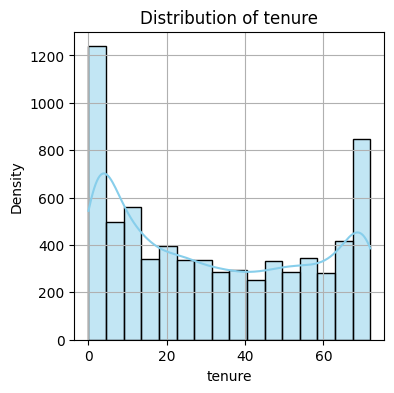

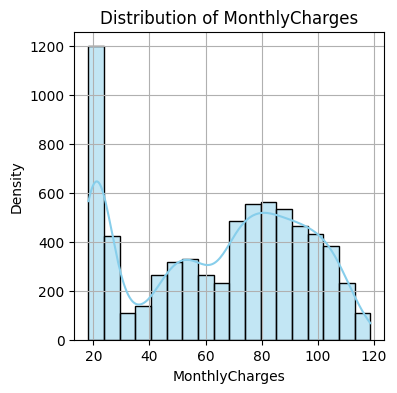

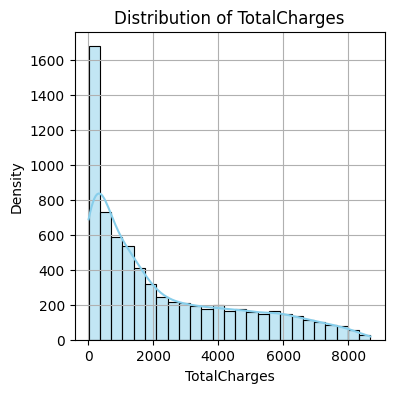

In [8]:
list_numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges'] 

#plot distribution of numeric variables
for col in list_numeric_features:
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(4, 4))
        sns.histplot(data=df, x=col, kde=True, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.grid(True)
        plt.show()



observation 
- total charges is right skewed. majority of customer have total charges between 18 (minimum value as seen in summary statistics results earlier) to 2000


- distribution of tenure represents a bimodal curve as it has 2 peaks at the extremes


check for outliears

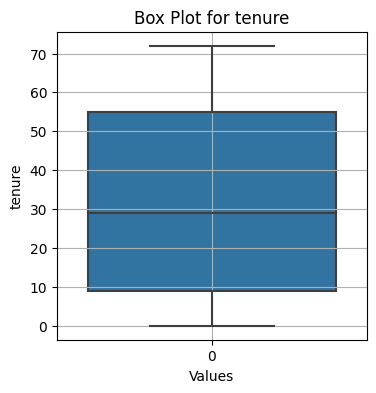

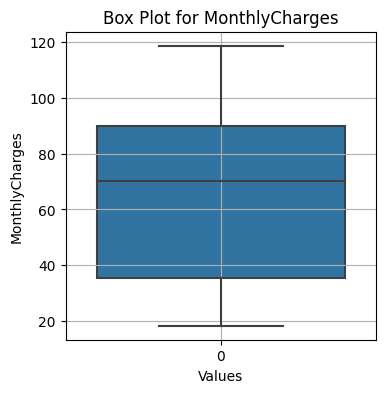

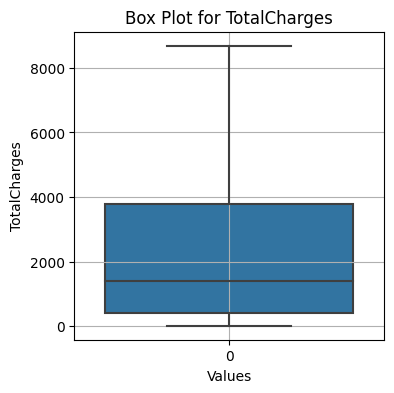

In [9]:
#check for outliers 
#outlier detection 
for col in list_numeric_features:
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df[col])
    plt.title(f'Box Plot for {col}')
    plt.xlabel('Values')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

#OBSERVATION - No outliers in the data 

#Explore numeric features and their relationship with the outcome - Churn

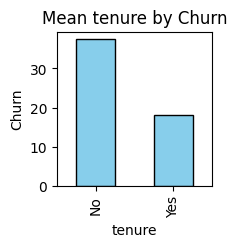

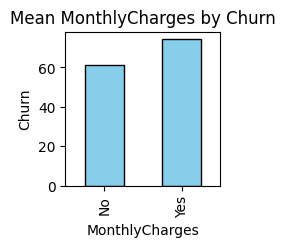

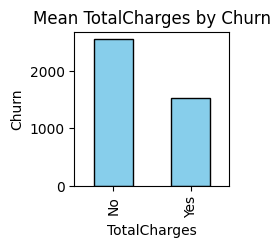

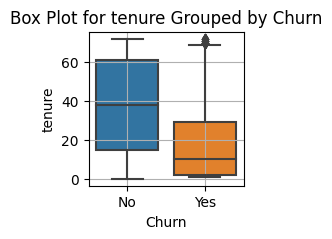

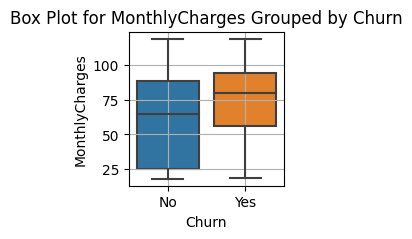

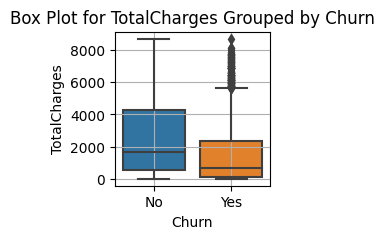

In [10]:
 

# compare mean of those who churn vs those who don't 
for col in list_numeric_features:
    plt.figure(figsize=(2,2))
    group_mean = df.groupby('Churn')[col].mean()
    group_mean.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Churn')
    plt.title(f'Mean {col} by Churn')
    plt.show()

#Compare the mean values of numeric features for customer who churned vs who did not 
for col in list_numeric_features:
    plt.figure(figsize=(2,2))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'Box Plot for {col} Grouped by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()
    



OBSERVATION 
  - Average tenure of those who churn is very low compared to that of customers who stayed
    - This suggestss that churn likely happens in  early stage of customer journey 
  - Monthly charges of those who churn are higher than that of customers who stayed 
  - Total charges are higher for those who stayed
- Median tenure of those who churn is only 10 months compared to median tenure of 40 months of those who stayed 
- 

Now we  will compare the Kernal Density plots of  these numeric variables for customers who chrun vs who don't. 
KDE plots will help us evaluate where the data is most concentrated in each category and help in 
visually identigying if there is good enough variability in distribution of these numeric features making them a good predictor. 


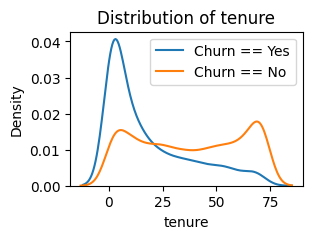

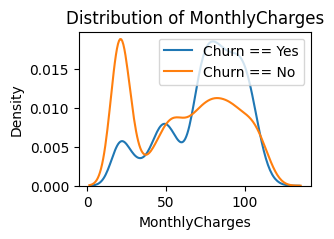

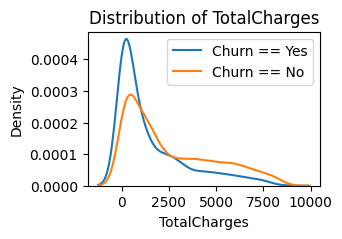

In [11]:
for col in list_numeric_features:
    plt.figure(figsize=(3, 2))

    # KDE plot of loans that were repaid on time
    sns.kdeplot(df.loc[df['Churn'] == 'Yes', col], label='Churn == Yes')
    sns.kdeplot(df.loc[df['Churn'] == 'No', col], label='Churn == No')

    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'Distribution of {col}')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

Observation 
- Those who churn have either a very short or very long tenure 
- Most of the customers who churn have higher monthly charges 

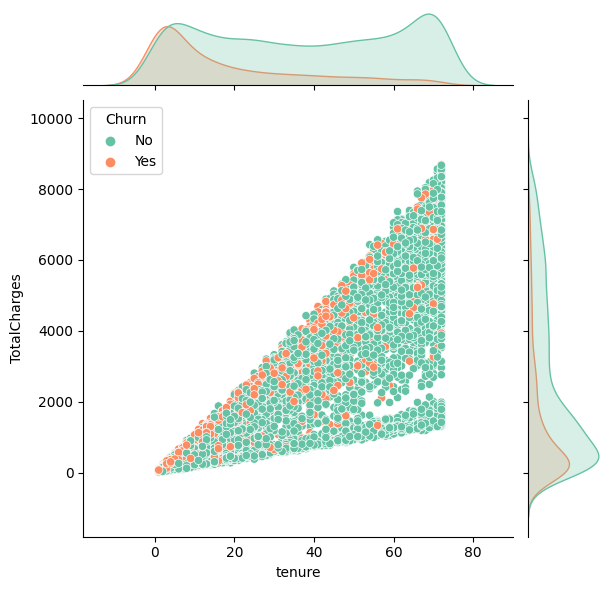

In [12]:
sns.jointplot(data=df, x='tenure', y='TotalCharges', palette='Set2', hue='Churn')
plt.show()

Variable correlation


Text(0.5, 1.05, 'Pearson correlation of Features')

<Figure size 200x200 with 0 Axes>

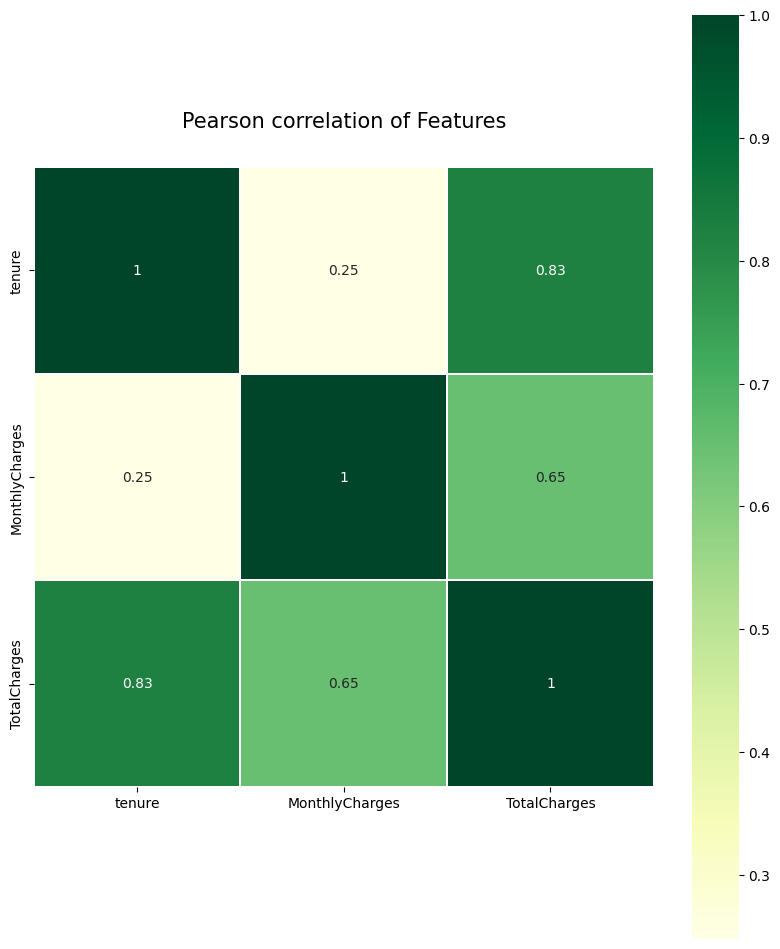

In [13]:

#correlation matrix to check for itercorrelation/ interactions among numeric predictors 

# evaluate correlation among independent numericx variables 
print('Variable correlation')
plt.figure(figsize=(2, 2))

%matplotlib inline
corr = df[list_numeric_features].corr()

f, ax = plt.subplots(figsize=(10,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

Total Charges is highly correlated with Tenure and Monthly Charges. 
Essentially total charges = Tenure * Monthly Charges 
So to avoid multi-collinarity issues we will exclude Total Charges for building the predictive model

Exploring Categorical Features 
- We will look at how the chrun rate differs across categories 
- We will also run Chi square test of independence to identify categorical variables that have signifiant relation with the Chrun category we want to predict. 


In [14]:
#list the categorical features, check how many distinct values each category has 
cat_vars = df.select_dtypes(include=['O']).columns.tolist()
print(f'number categorical features: {len(cat_vars)}')
#The 'Churn' response variable is removed for the cat_vars list 
cat_vars.remove('Churn')
print(df[cat_vars].nunique())
#remove customer ID from the list 
cat_vars.remove('customerID')

number categorical features: 17
customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
dtype: int64


In [15]:
#running the chi square test 

# Loop through each categorical feature and identify those that are significant 
sig_cat_vars = []
for col in cat_vars:
    
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['Churn'])
        
    # Perform chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
        
    # print(f"Chi-square p-value for {col}: {p}")
    if p <= 0.05:
     sig_cat_vars.append(col)
print(len(sig_cat_vars))
print(sig_cat_vars)

13
['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


- Of the 16 categorical variables, 13 have significant relation with the Chrun category we want to predict
- Let us further look at the churn rate for each of these categories 


Axes(0.125,0.11;0.775x0.77)


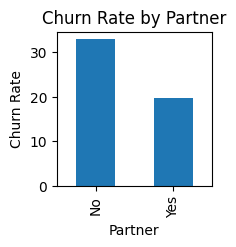

Axes(0.125,0.11;0.775x0.77)


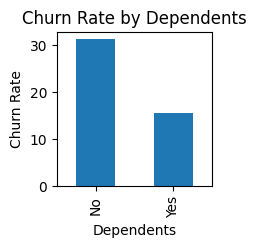

Axes(0.125,0.11;0.775x0.77)


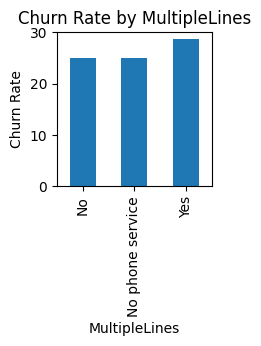

Axes(0.125,0.11;0.775x0.77)


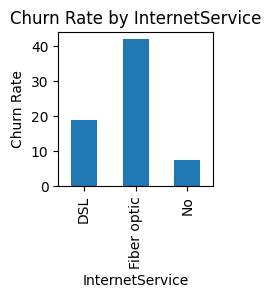

Axes(0.125,0.11;0.775x0.77)


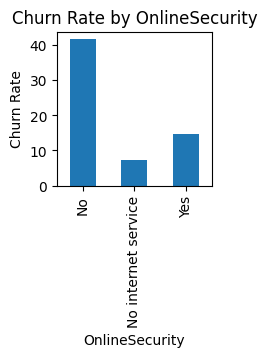

Axes(0.125,0.11;0.775x0.77)


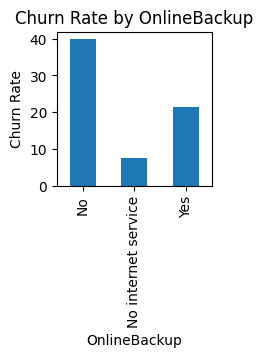

Axes(0.125,0.11;0.775x0.77)


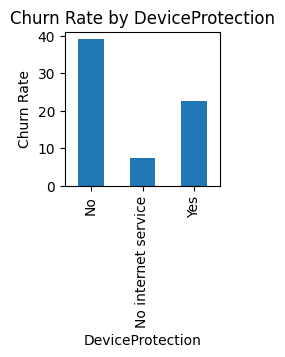

Axes(0.125,0.11;0.775x0.77)


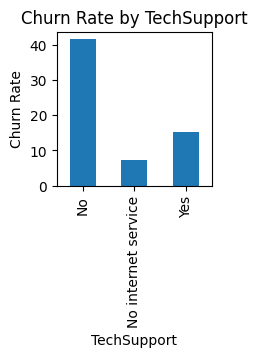

Axes(0.125,0.11;0.775x0.77)


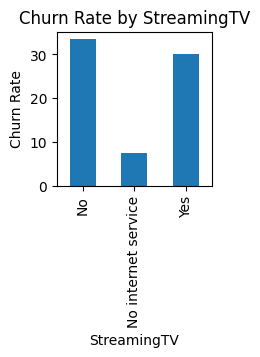

Axes(0.125,0.11;0.775x0.77)


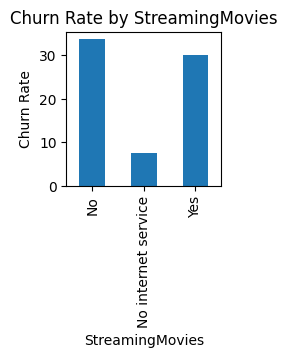

Axes(0.125,0.11;0.775x0.77)


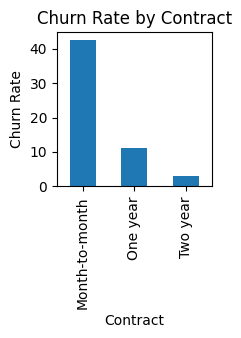

Axes(0.125,0.11;0.775x0.77)


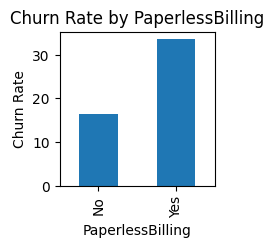

Axes(0.125,0.11;0.775x0.77)


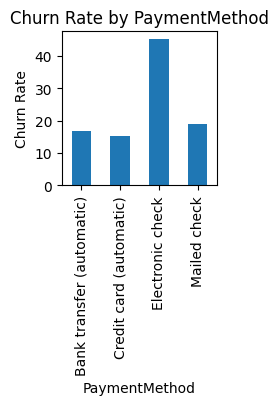

In [16]:
# Plot the risk % by various categorical variables 
for col in sig_cat_vars: 
    plt.figure(figsize=(2, 2))
    risk_pct = df.groupby(col).apply(lambda x: x['Churn_Target'].sum() * 100/ len(x['Churn_Target']))
#     print(f'% of customers at risk by {col}')
    print(risk_pct.plot.bar())
    # Set title and labels
    plt.title('Churn Rate by ' + col)  # Set the title
    plt.xlabel(col)  # Set the label for the x-axis
    plt.ylabel('Churn Rate')  # Set the label for the y-axis

    # Show the plot
    plt.show()

observation 


In [17]:
 

#variable importance other than random forest 

#next steps for feature engg interaction variable  / level grouping 